<a href="https://colab.research.google.com/github/jasmis1229/task3-1/blob/main/task3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52376 (\N{HANGUL SYLLABLE CEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

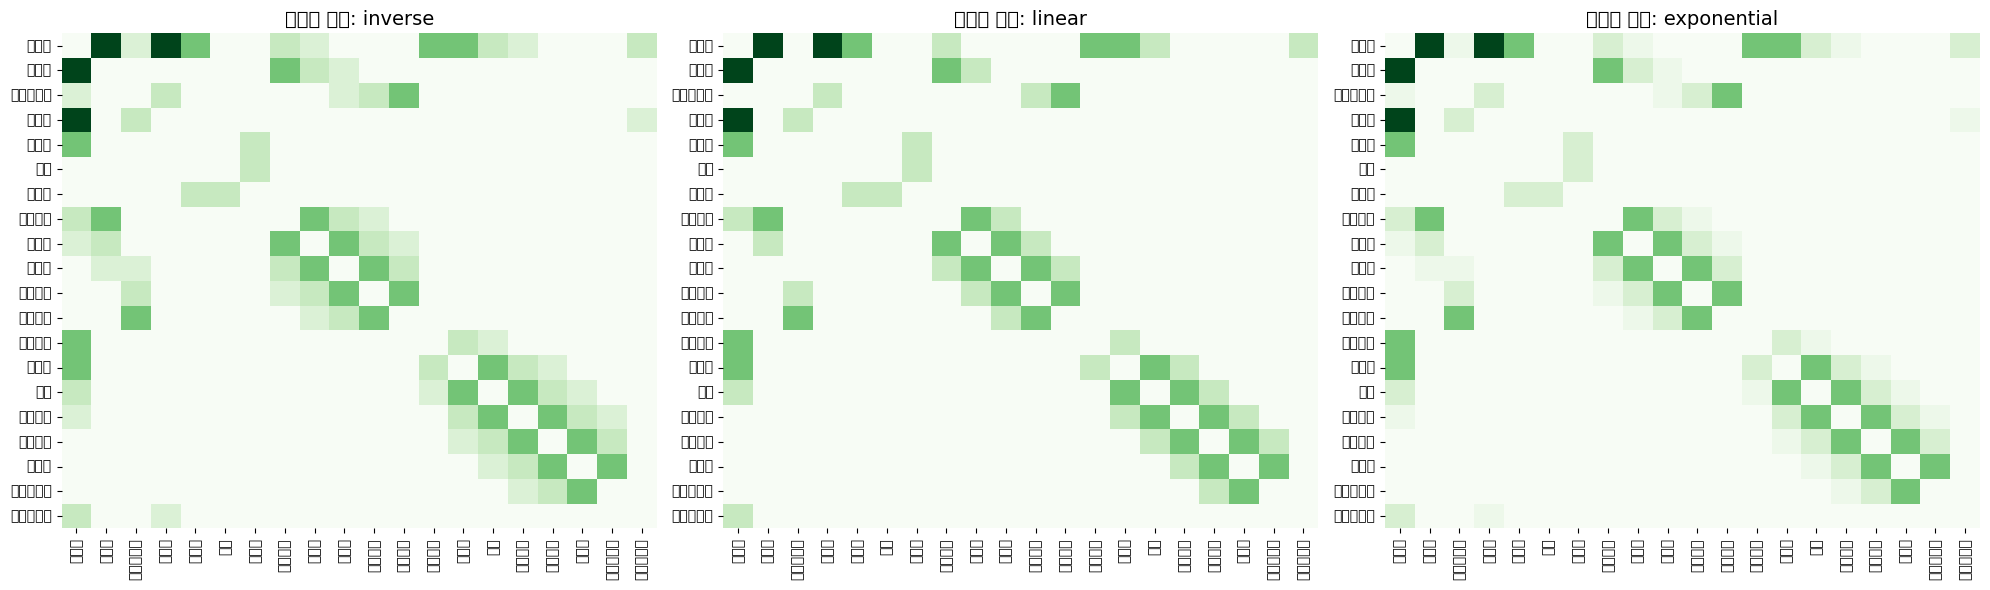

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import sparse
import pickle

# 📦 전처리 데이터 불러오기
with open("/content/preprocessing_results.pkl", "rb") as f:
    preprocessed = pickle.load(f)

tokenized_corpus = preprocessed['tokenized_corpus']
word_to_id = preprocessed['word_to_id']
id_to_word = preprocessed['id_to_word']

# 🔧 동시출현 행렬 생성 함수 (가중치 방식 지정)
def build_weighted_cooccurrence(tokenized_corpus, word_to_id, window_size=3, method="inverse"):
    vocab_size = len(word_to_id)
    cooccurrence_dict = defaultdict(float)

    for sentence in tokenized_corpus:
        sentence_length = len(sentence)
        for i, center_word in enumerate(sentence):
            if center_word not in word_to_id:
                continue
            center_id = word_to_id[center_word]
            window_start = max(0, i - window_size)
            window_end = min(sentence_length, i + window_size + 1)
            for j in range(window_start, window_end):
                if i == j:
                    continue
                context_word = sentence[j]
                if context_word not in word_to_id:
                    continue
                context_id = word_to_id[context_word]
                distance = abs(j - i)

                # ✅ 가중치 방식에 따른 weight 계산
                if method == "inverse":
                    weight = 1.0 / distance
                elif method == "linear":
                    weight = max(0, 1 - (distance / window_size))
                elif method == "exponential":
                    weight = np.exp(-distance)
                else:
                    weight = 1.0  # fallback

                cooccurrence_dict[(center_id, context_id)] += weight

    row_indices = []
    col_indices = []
    data = []
    for (i, j), value in cooccurrence_dict.items():
        row_indices.append(i)
        col_indices.append(j)
        data.append(value)

    cooccurrence_matrix = sparse.csr_matrix((data, (row_indices, col_indices)), shape=(vocab_size, vocab_size))
    return cooccurrence_matrix

# 🔬 가중치 방식별 행렬 생성
methods = ["inverse", "linear", "exponential"]
matrices = {m: build_weighted_cooccurrence(tokenized_corpus, word_to_id, window_size=3, method=m) for m in methods}

# 🎨 상위 단어 기준 시각화
top_words = list(word_to_id.keys())[:20]
indices = [word_to_id[w] for w in top_words]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for idx, m in enumerate(methods):
    submatrix = matrices[m][indices, :][:, indices].todense()
    sns.heatmap(np.array(submatrix), xticklabels=top_words, yticklabels=top_words, ax=axes[idx], cmap="Greens", cbar=False)
    axes[idx].set_title(f"가중치 방식: {m}", fontsize=14)
    axes[idx].tick_params(axis='x', rotation=90)
    axes[idx].tick_params(axis='y', rotation=0)
plt.tight_layout()
plt.show()

Selecting previously unselected package fonts-nanum.
(Reading database ... 126315 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


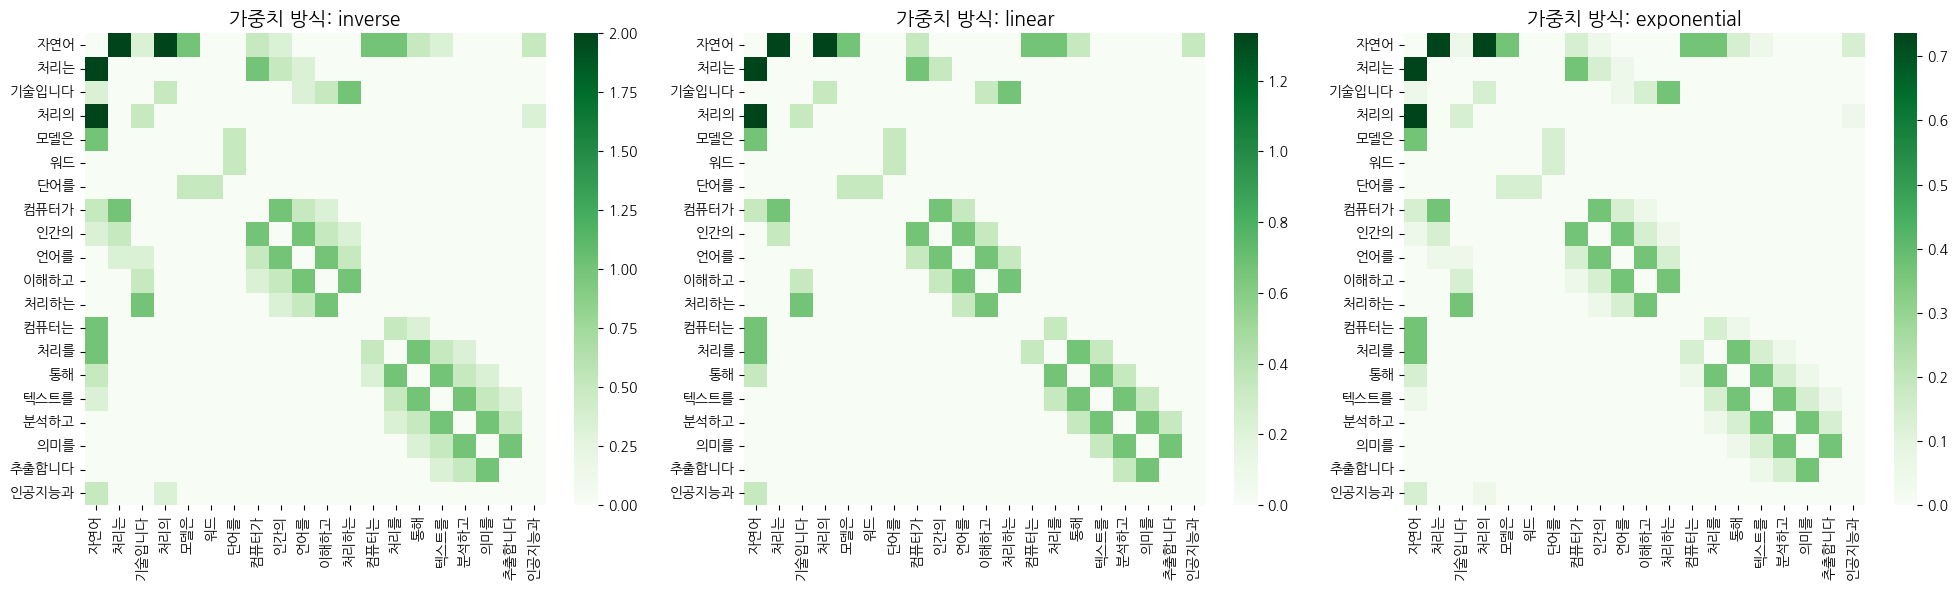

In [2]:
# 🔧 한글 폰트 설정 (한 번만 실행하면 됨)
!apt-get -qq install -y fonts-nanum
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
for font in font_list:
    fm.fontManager.addfont(font)

# 라이브러리
import seaborn as sns
from collections import defaultdict
from scipy import sparse
import numpy as np
import pickle

# 전처리 결과 로드
with open("/content/preprocessing_results.pkl", "rb") as f:
    preprocessed = pickle.load(f)

tokenized_corpus = preprocessed['tokenized_corpus']
word_to_id = preprocessed['word_to_id']
id_to_word = preprocessed['id_to_word']

# 거리 기반 가중치 방식에 따른 GloVe 행렬 함수
def build_weighted_matrix(tokenized_corpus, word_to_id, window_size=3, method="inverse"):
    vocab_size = len(word_to_id)
    cooccur = defaultdict(float)

    for sentence in tokenized_corpus:
        for i, center in enumerate(sentence):
            if center not in word_to_id:
                continue
            center_id = word_to_id[center]
            for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
                if i == j or sentence[j] not in word_to_id:
                    continue
                context_id = word_to_id[sentence[j]]
                distance = abs(j - i)

                # ✅ 다양한 거리 가중치 방식
                if method == "inverse":
                    weight = 1.0 / distance
                elif method == "linear":
                    weight = max(0, 1 - distance / window_size)
                elif method == "exponential":
                    weight = np.exp(-distance)
                else:
                    weight = 1.0  # fallback

                cooccur[(center_id, context_id)] += weight

    row, col, data = zip(*[(i, j, v) for (i, j), v in cooccur.items()])
    return sparse.csr_matrix((data, (row, col)), shape=(vocab_size, vocab_size))

# 세 가지 방식으로 행렬 생성
methods = ["inverse", "linear", "exponential"]
matrices = {
    m: build_weighted_matrix(tokenized_corpus, word_to_id, window_size=3, method=m)
    for m in methods
}

# 단어 목록 (20개까지)
top_words = list(word_to_id.keys())[:20]
indices = [word_to_id[w] for w in top_words]

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for idx, m in enumerate(methods):
    mat = matrices[m][indices, :][:, indices].todense()
    sns.heatmap(mat, xticklabels=top_words, yticklabels=top_words, ax=axes[idx], cmap="Greens", annot=False)
    axes[idx].set_title(f"가중치 방식: {m}", fontsize=14)
    axes[idx].tick_params(axis='x', rotation=90)
    axes[idx].tick_params(axis='y', rotation=0)
plt.tight_layout()
plt.show()